In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import auc
import seaborn as sns

In [2]:
plt.style.use('default')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 10),
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large'}
plt.rcParams.update(params)

In [3]:
color_dict = {'FINEMAP': 'lime',
              'SuSiE': 'royalblue',
              'PAINTOR-': 'orchid',
              'PAINTOR+': 'darkmagenta',
              'SparsePro-': 'orange',
              'SparsePro+': 'red',
              'SparsePro+1.0': 'darkred',
              'SuSiE+SparsePro': 'darkblue',
              'SuSiE+HESS': 'lightblue'}

## Plotting functions

In [4]:
def get_Tv(SNPlist, wdir, rep=50):
    Tv = pd.concat([SNPlist.isin(pd.read_csv(os.path.join(wdir, 'C{}.causal'.format(i)), sep='\t', header=None)[0])
                    for i in range(1, rep + 1)])
    return Tv.values

In [5]:
def load_pipeline_results(wdir, method, rep=50):
    """Load results of fine-mapping pipelines"""
    if method == 'FINEMAP':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "C{}.snp".format(i)), sep=' ').sort_values(by=['index'])['prob']
                         for i in range(1, rep + 1)])
    elif method == 'PAINTOR-':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "PAINTOR_no/C{}.results".format(i)), sep=' ')
                         for i in range(1, rep + 1)])['Posterior_Prob']
    elif method == 'PAINTOR+':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "PAINTOR_anno/C{}.results".format(i)), sep=' ')
                         for i in range(1, rep + 1)])['Posterior_Prob']
    elif method == 'SparsePro-':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "sparsepro_no/C{}.txt.pip".format(i)), sep='\t', header=None)
                         for i in range(1, rep + 1)])[2]
    elif method == 'SparsePro+1.0':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "sparsepro_anno_all/C{}.txt.pip".format(i)), sep='\t', header=None)
                         for i in range(1, rep + 1)])[2]
    elif method == 'SparsePro+':
        if os.path.exists(os.path.join(wdir, 'sparsepro_anno/C1.txt.pip')):
            PIP = pd.concat([pd.read_csv(os.path.join(wdir, "sparsepro_anno/C{}.txt.pip".format(i)), sep='\t', header=None)
                             for i in range(1, rep + 1)])[2]
        else:
            PIP = pd.concat([pd.read_csv(os.path.join(wdir, "sparsepro_no/C{}.txt.pip".format(i)), sep='\t', header=None)
                             for i in range(1, rep + 1)])[2]
    elif method == 'SuSiE':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "susie_rss/C{}.txt.pip".format(i)), sep='\t', header=None)[2]
                         for i in range(1, rep + 1)])
    elif method == 'SuSiE+HESS':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "susie_sparsepro/C{}.txt.pip".format(i)), sep='\t', header=None)[2]
                         for i in range(1, rep + 1)])
    elif method == 'SuSiE+SparsePro':
        PIP = pd.concat([pd.read_csv(os.path.join(wdir, "susie_sparsepro/C{}.txt.pip".format(i)), sep='\t', header=None)[3]
                         for i in range(1, rep + 1)])
    else:
        raise ValueError("Invalid method name.")
    return PIP.values

In [6]:
def load_all_PIP(wdir, mlist, rep=50):
    SNPlist = pd.read_csv(os.path.join(wdir, 'sparsepro_no/C1.txt.pip'), sep='\t', header=None)[0]
    Tv = get_Tv(SNPlist, wdir, rep)
    mPIP = {}
    for m in mlist:
        mPIP[m] = load_pipeline_results(wdir, m)
    return Tv, mPIP

In [7]:
def ant_plot(ax, Tv, PIP1, PIP2, name1, name2):
    """plot PIP contrast"""
    ax.scatter(x=PIP1[[not i for i in Tv]], y=PIP2[[not i for i in Tv]], c='black', s=100, label='Non-causal')
    ax.scatter(x=PIP1[Tv], y=PIP2[Tv], c='red', s=100, label='Causal')
    ax.set_xlabel(name1, fontsize=25)
    ax.set_ylabel(name2, fontsize=25)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
    ax.grid()
    return ax

In [8]:
def ant_plot_no(Tv, mPIP):
    """PIP plot without annotations"""
    fig, axs = plt.subplots(1, 3, figsize=(30, 9))
    ant_plot(axs[0], Tv, mPIP['SparsePro-'], mPIP['FINEMAP'], 'SparsePro- PIP', 'FINEMAP PIP')
    ant_plot(axs[1], Tv, mPIP['SparsePro-'], mPIP['SuSiE'], 'SparsePro- PIP', 'SuSiE PIP')
    ant_plot(axs[2], Tv, mPIP['SparsePro-'], mPIP['PAINTOR-'], 'SparsePro- PIP', 'PAINTOR- PIP')

In [9]:
def ant_plot_anno(Tv, mPIP):
    """PIP plot with annotations"""
    fig, axs = plt.subplots(1, 3, figsize=(30, 9))
    ant_plot(axs[0], Tv, mPIP['SparsePro+'], mPIP['SparsePro-'], 'SparsePro+ PIP', 'SparsePro- PIP')
    ant_plot(axs[1], Tv, mPIP['PAINTOR+'], mPIP['PAINTOR-'], 'PAINTOR+ PIP', 'PAINTOR- PIP')
    ant_plot(axs[2], Tv, mPIP['SparsePro+'], mPIP['PAINTOR+'], 'SparsePro+ PIP', 'PAINTOR+ PIP')

In [10]:
def get_auprc(PIP, Tv):
    precision, recall, thresholds = precision_recall_curve(Tv, PIP)
    return auc(recall, precision)

In [11]:
def prc_plot(ax, PIP, Tv, name, color):
    precision, recall, thresholds = precision_recall_curve(Tv, PIP)
    ax.plot(recall, precision, label=name + ": " + "{:.2f}".format(auc(recall, precision)), color=color)
    ax.set_ylabel('Precision', fontsize=22)
    ax.set_xlabel('Recall', fontsize=22)
    return ax

In [12]:
def prc_plot_method(Tv, mPIP, mlist):
    fig, ax = plt.subplots(figsize=(10, 10))
    for m in mlist:
        prc_plot(ax, mPIP[m], Tv, m, color_dict[m])
    ax.legend()

In [13]:
def calib_plot(ax, PIP, Tv, name, color):
    cp, mpv = calibration_curve(Tv, PIP)
    ax.plot(mpv, cp, marker='.', label=name, color=color)
    ax.set_ylabel('Actual Precision', fontsize=22)
    ax.set_xlabel('Expected Precision', fontsize=22)
    return ax

In [14]:
def calibration_plot_method(Tv, mPIP, mlist):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot([0, 1], [0, 1], '--', color='grey')
    for m in mlist:
        calib_plot(ax, mPIP[m], Tv, m, color_dict[m])
    ax.legend()

In [15]:
def get_Tv_cs_coverage_power_size(wdir, method, ite):
    causal = pd.read_csv(os.path.join(wdir, 'C{}.causal'.format(ite)), header=None, sep='\t')[0]
    if method == 'SparsePro-':
        cs = pd.read_csv(os.path.join(wdir, 'sparsepro_no', 'C{}.txt.cs'.format(ite)), sep='\t')
    elif method == 'SparsePro+1.0':
        cs = pd.read_csv(os.path.join(wdir, 'sparsepro_anno_all', 'C{}.txt.cs'.format(ite)), sep='\t')
    elif method == 'SuSiE':
        cs = pd.read_csv(os.path.join(wdir, 'susie_rss', 'C{}.txt.cs'.format(ite)), sep='\t')
    elif method == 'SuSiE+SparsePro':
        cs = pd.read_csv(os.path.join(wdir, 'susie_sparsepro', 'C{}.txt.sp.cs'.format(ite)), sep='\t')
    elif method == 'SuSiE+HESS':
        cs = pd.read_csv(os.path.join(wdir, 'susie_sparsepro', 'C{}.txt.cs'.format(ite)), sep='\t')
    elif method == 'SparsePro+':
        if not os.path.exists(os.path.join(wdir, 'sparsepro_anno', 'C{}.txt.cs'.format(ite))):
            cs = pd.read_csv(os.path.join(wdir, 'sparsepro_no', 'C{}.txt.cs'.format(ite)), sep='\t')
        else:
            cs = pd.read_csv(os.path.join(wdir, 'sparsepro_anno', 'C{}.txt.cs'.format(ite)), sep='\t')
    else:
        raise ValueError("Invalid method name.")
    tcs = len(cs)  # total cs
    if tcs == 0:
        return 0, 0, 0
    cseff = [set(i.split('/')) for i in cs['cs']]
    cstrue = [i & set(causal) for i in cseff]
    sc = np.sum([len(i)>0 for i in cstrue])  # right cs
    tss = np.sum([len(i) for i in cseff])  # total set size
    return tcs, sc, tss

In [16]:
def get_coverage_power_size(wdir, method, K, nite=50):
    tcs, sc, tss = tuple(sum(x) for x in zip(*[get_Tv_cs_coverage_power_size(wdir, method, i) for i in range(1, 1+nite)]))
    coverage = sc/tcs
    size = tss/tcs
    power = sc/K/nite
    return coverage, size, power

## Plotting examples

In [17]:
Tv, mPIP = load_all_PIP('../sim/loc/22_31000000_32000000/K5_W2', ['FINEMAP', 'SuSiE', 'PAINTOR-', 'PAINTOR+', 'SparsePro-', 'SparsePro+', 'SuSiE+HESS', 'SuSiE+SparsePro', 'SparsePro+1.0'], rep=50)

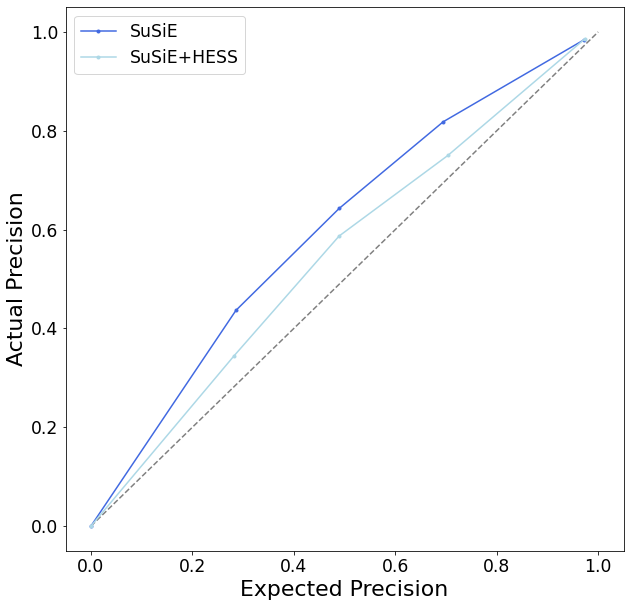

In [19]:
calibration_plot_method(Tv, mPIP, ['SuSiE', 'SuSiE+HESS'])

<Axes: xlabel='SuSiE PIP', ylabel='SuSiE+HESS PIP'>

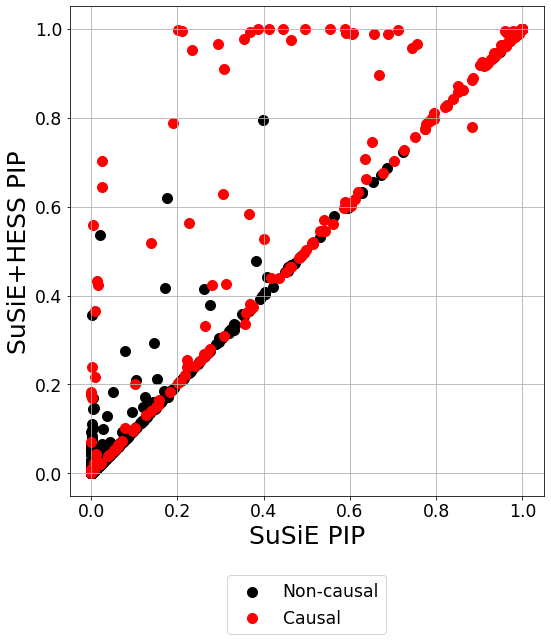

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(8.5,9))
ant_plot(axs, Tv, mPIP['SuSiE'], mPIP['SuSiE+HESS'], 'SuSiE PIP', 'SuSiE+HESS PIP')

<Axes: xlabel='SparsePro- PIP', ylabel='SuSiE+HESS PIP'>

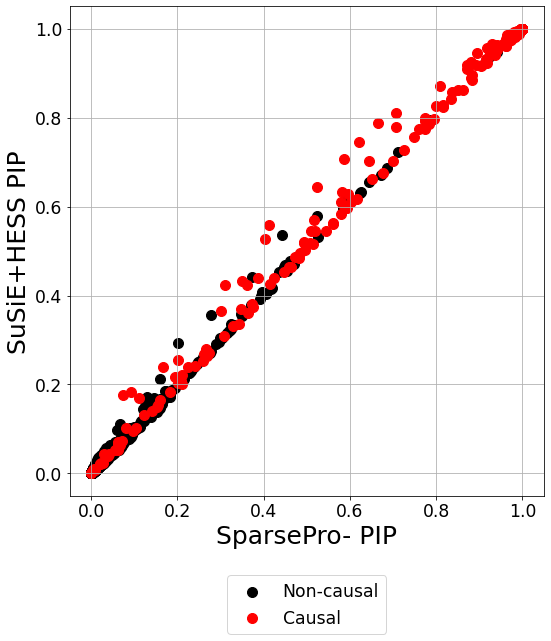

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(8.5,9))
ant_plot(axs, Tv, mPIP['SparsePro-'], mPIP['SuSiE+HESS'], 'SparsePro- PIP', 'SuSiE+HESS PIP')

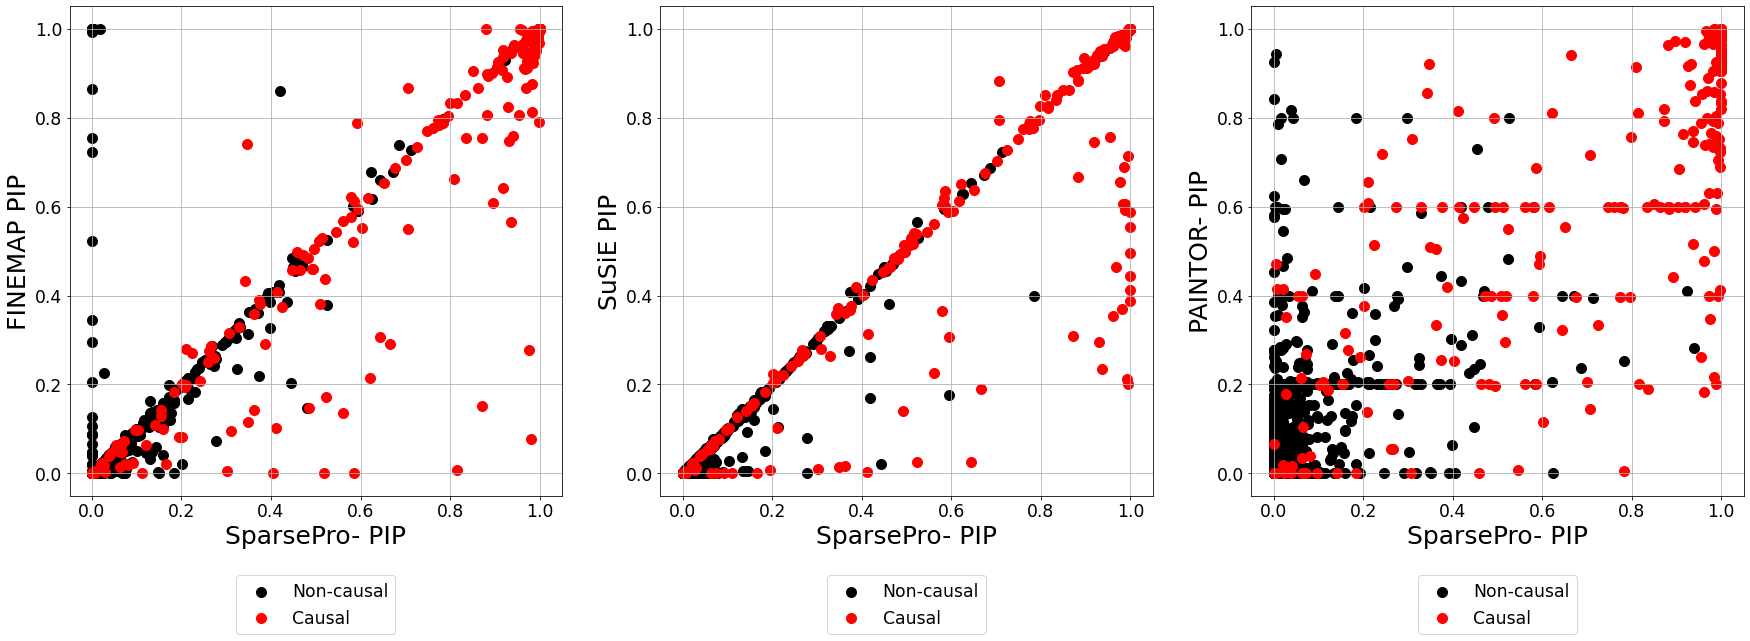

In [18]:
ant_plot_no(Tv, mPIP)

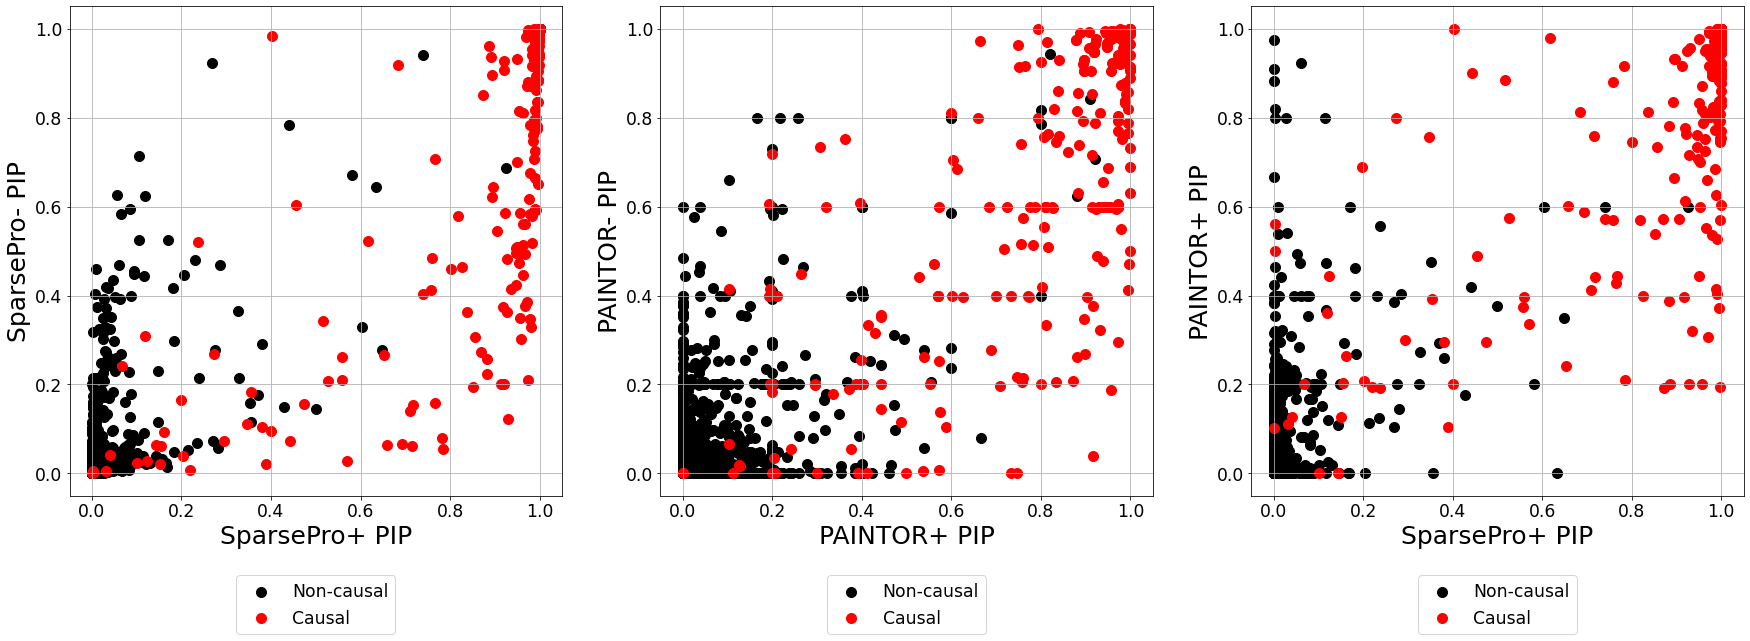

In [19]:
ant_plot_anno(Tv, mPIP)

<Axes: xlabel='SparsePro+ PIP', ylabel='SparsePro+1.0 PIP'>

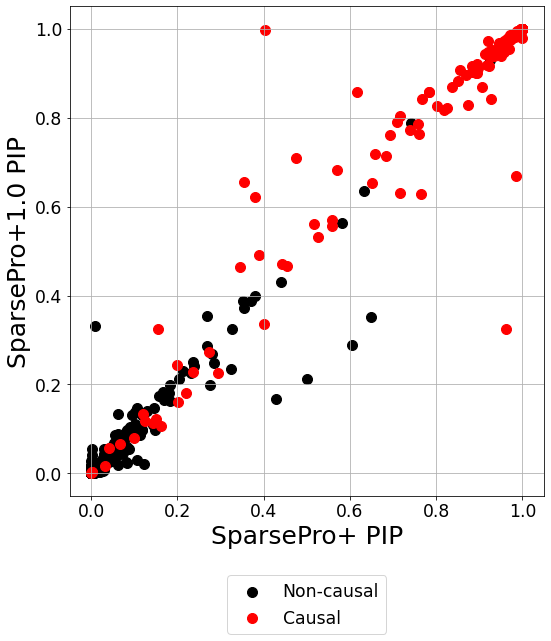

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(8.5,9))
ant_plot(axs, Tv, mPIP['SparsePro+'], mPIP['SparsePro+1.0'], 'SparsePro+ PIP', 'SparsePro+1.0 PIP')

<Axes: xlabel='SparsePro- PIP', ylabel='SuSiE+SparsePro PIP'>

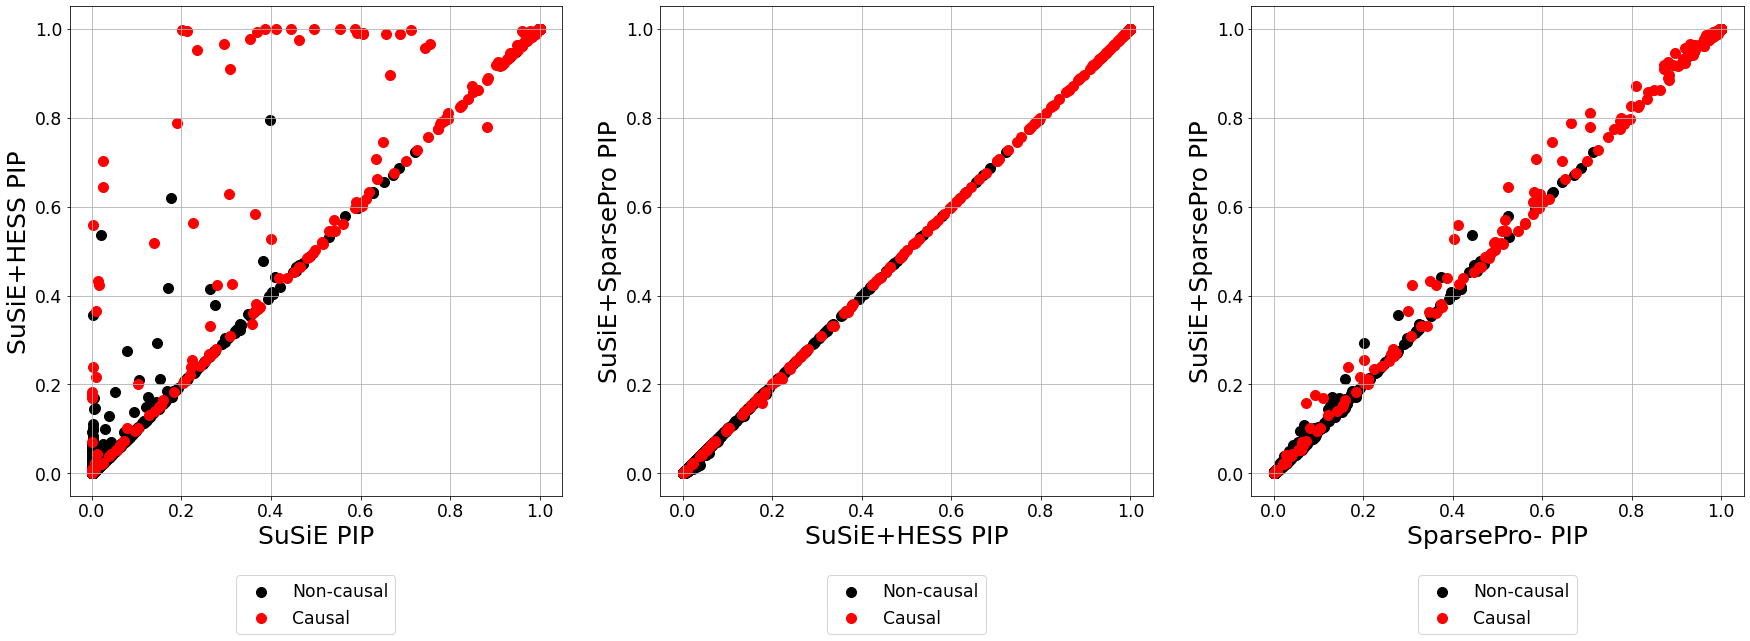

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(30,9))
ant_plot(axs[0], Tv, mPIP['SuSiE'], mPIP['SuSiE+HESS'], 'SuSiE PIP', 'SuSiE+HESS PIP')
ant_plot(axs[1], Tv, mPIP['SuSiE+HESS'], mPIP['SuSiE+SparsePro'], 'SuSiE+HESS PIP', 'SuSiE+SparsePro PIP')
ant_plot(axs[2], Tv, mPIP['SparsePro-'], mPIP['SuSiE+SparsePro'], 'SparsePro- PIP', 'SuSiE+SparsePro PIP')

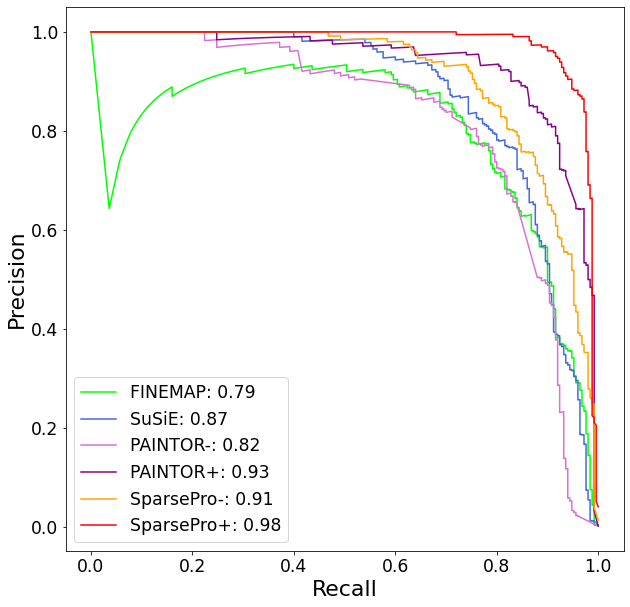

In [22]:
prc_plot_method(Tv, mPIP, ['FINEMAP', 'SuSiE', 'PAINTOR-', 'PAINTOR+', 'SparsePro-', 'SparsePro+'])

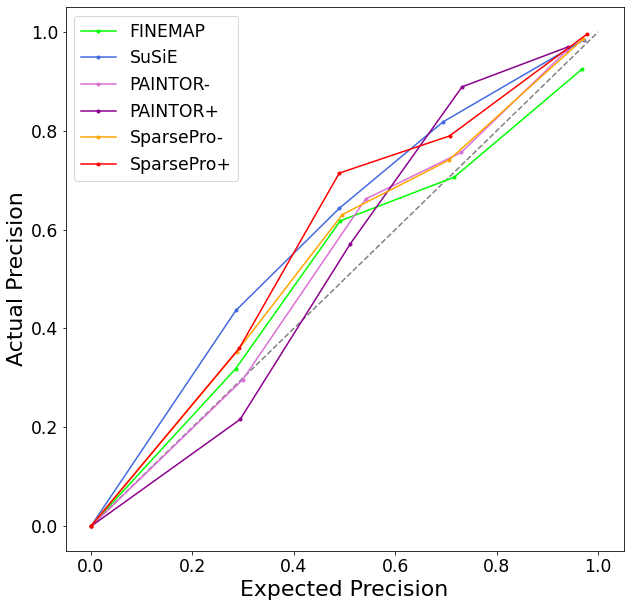

In [23]:
calibration_plot_method(Tv, mPIP, ['FINEMAP', 'SuSiE', 'PAINTOR-', 'PAINTOR+', 'SparsePro-', 'SparsePro+'])

## AUPRC summary plot

In [5]:
locus_dict = {'Locus1': '22_31000000_32000000',
              'Locus2': '21_31000000_32000000',
              'Locus3': '20_31000000_32000000'}

In [6]:
mlist = ['FINEMAP', 'SuSiE', 'PAINTOR-', 'PAINTOR+', 'SparsePro-', 'SparsePro+', 'SuSiE+HESS', 'SuSiE+SparsePro', 'SparsePro+1.0']

In [7]:
df_auprc = pd.read_csv('../doc/loc_auprc.txt', sep='\t')

In [8]:
df_auprc_long = pd.melt(df_auprc, id_vars=['Locus', 'K', 'W'], value_vars=mlist, var_name='Method', value_name='AUPRC')

In [22]:
sns.set_context('talk')

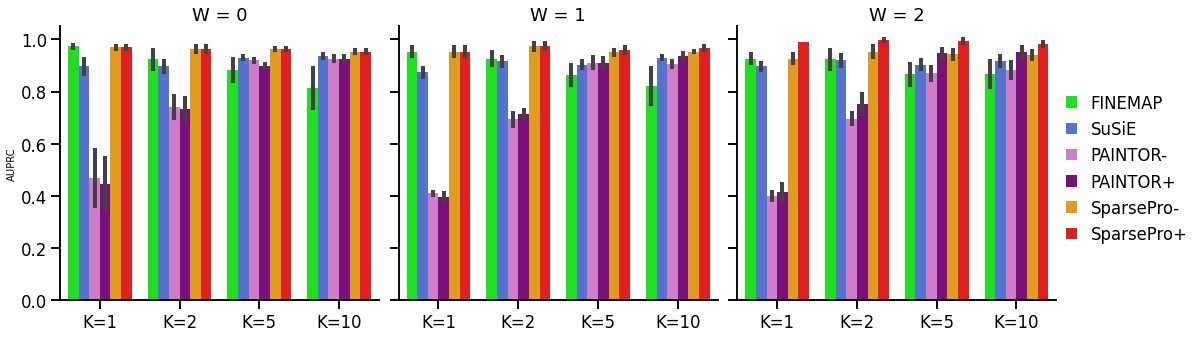

In [10]:
g = sns.catplot(df_auprc_long[df_auprc_long['Method'].isin(['FINEMAP', 'SuSiE', 'PAINTOR-', 'PAINTOR+', 'SparsePro-', 'SparsePro+'])],
                x='K',
                y='AUPRC',
                col='W',
                hue='Method',
                kind='bar',
                errorbar='se',
                palette=color_dict,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','AUPRC')
g.add_legend(title='', handlelength=0.7)

## Credible set summary plot

In [11]:
mlist = ['SuSiE', 'SparsePro-', 'SparsePro+', 'SuSiE+HESS', 'SuSiE+SparsePro', 'SparsePro+1.0']

In [12]:
df_cs = pd.read_csv('../doc/loc_cs.txt', sep='\t')

In [13]:
df_cs.query('Locus=="Locus1" and K==5 and W==2')

,Locus,K,W,Method,Coverage,Size,Power
48,Locus1,5,2,SuSiE,0.977778,2.922222,0.704
49,Locus1,5,2,SparsePro-,0.981221,2.295775,0.836
50,Locus1,5,2,SparsePro+,0.995745,1.672340,0.936
51,Locus1,5,2,SuSiE+HESS,0.976415,3.028302,0.828
52,Locus1,5,2,SuSiE+SparsePro,0.977376,2.285068,0.864
53,Locus1,5,2,SparsePro+1.0,0.995745,1.612766,0.936


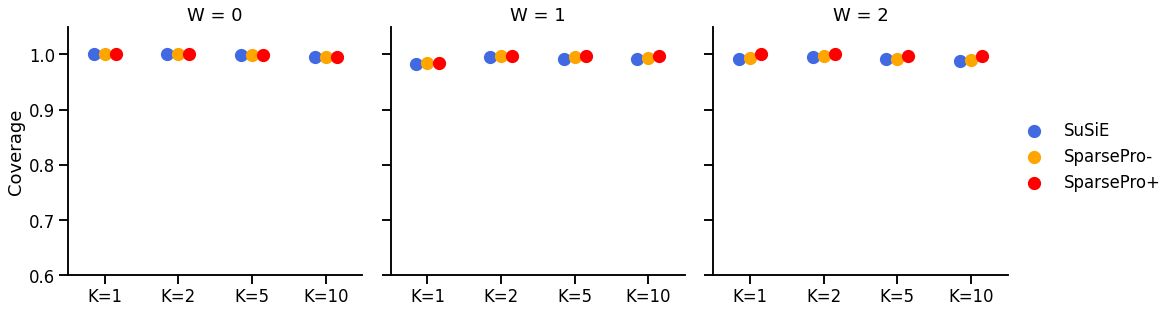

In [23]:
g = sns.catplot(df_cs[df_cs['Method'].isin(['SuSiE', 'SparsePro-', 'SparsePro+'])],
                x='K',
                y='Coverage',
                col='W',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette=color_dict,
                dodge=0.3,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Coverage')
g.add_legend(title='')
g.set(ylim=(0.6, 1.05))

In [72]:
df_cs

,Locus,K,W,Method,Coverage,Size,Power
0,Locus1,1,0,SuSiE,1.00,1.62,0.84
1,Locus1,1,0,SparsePro-,1.00,1.80,0.98
2,Locus1,1,0,SparsePro+,1.00,1.80,0.98
3,Locus1,1,0,SuSiE+HESS,1.00,1.62,0.84
4,Locus1,1,0,SuSiE+SparsePro,1.00,1.80,0.98
...,...,...,...,...,...,...,...
211,Locus3,10,2,SparsePro-,0.99,1.60,0.77
212,Locus3,10,2,SparsePro+,1.00,1.32,0.90
213,Locus3,10,2,SuSiE+HESS,1.00,1.57,0.82
214,Locus3,10,2,SuSiE+SparsePro,1.00,1.62,0.85


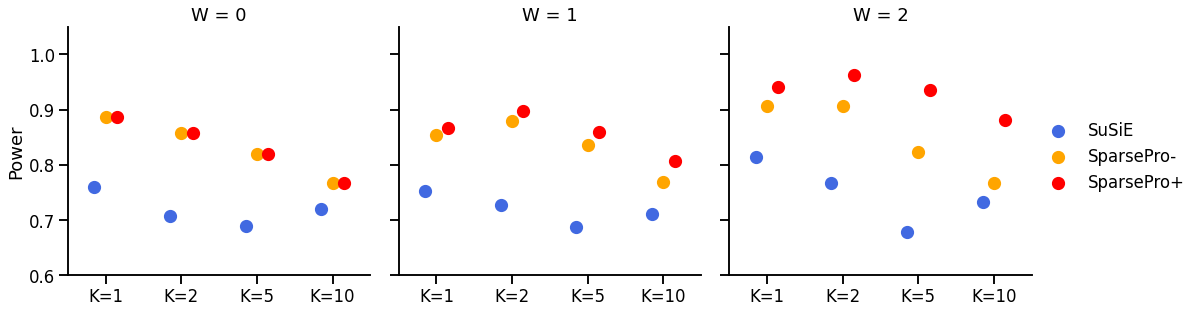

In [24]:
g = sns.catplot(df_cs[df_cs['Method'].isin(['SuSiE', 'SparsePro-', 'SparsePro+'])],
                x='K',
                y='Power',
                col='W',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette=color_dict,
                dodge=0.3,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Power')
g.add_legend(title='')
g.set(ylim=(0.6, 1.05))

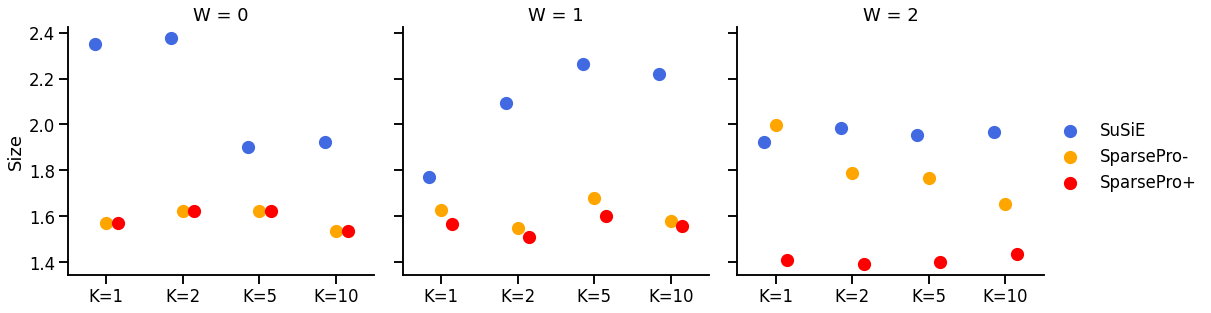

In [25]:
g = sns.catplot(df_cs[df_cs['Method'].isin(['SuSiE', 'SparsePro-', 'SparsePro+'])],
                x='K',
                y='Size',
                col='W',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette=color_dict,
                dodge=0.3,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Size')
g.add_legend(title='')

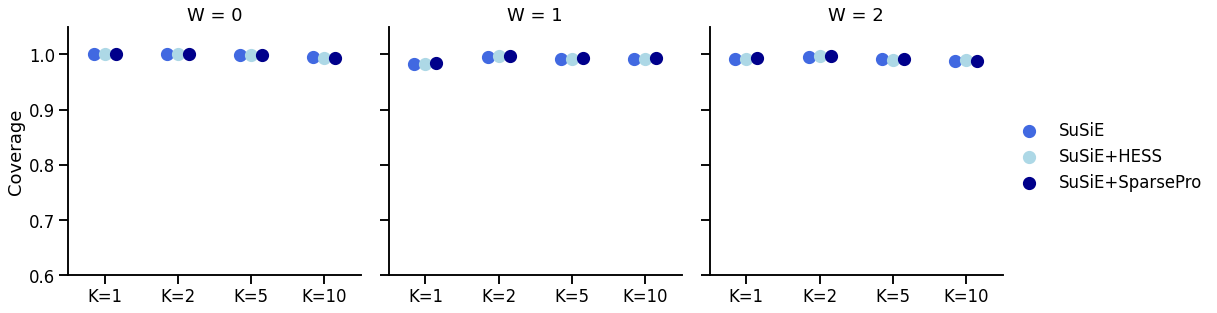

In [26]:
g = sns.catplot(df_cs[df_cs['Method'].isin(['SuSiE', 'SuSiE+HESS', 'SuSiE+SparsePro'])],
                x='K',
                y='Coverage',
                col='W',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette=color_dict,
                dodge=0.3,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Coverage')
g.add_legend(title='')
g.set(ylim=(0.6, 1.05))

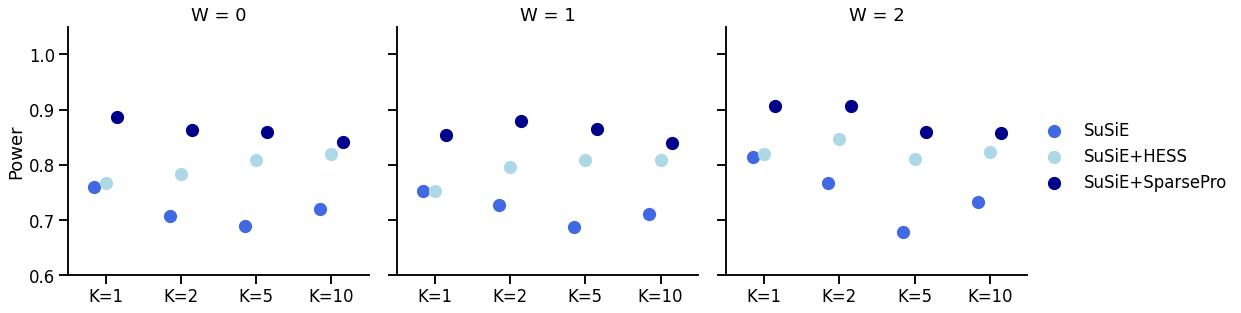

In [27]:
g = sns.catplot(df_cs[df_cs['Method'].isin(['SuSiE', 'SuSiE+HESS', 'SuSiE+SparsePro'])],
                x='K',
                y='Power',
                col='W',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette=color_dict,
                dodge=0.3,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Power')
g.add_legend(title='')
g.set(ylim=(0.6, 1.05))

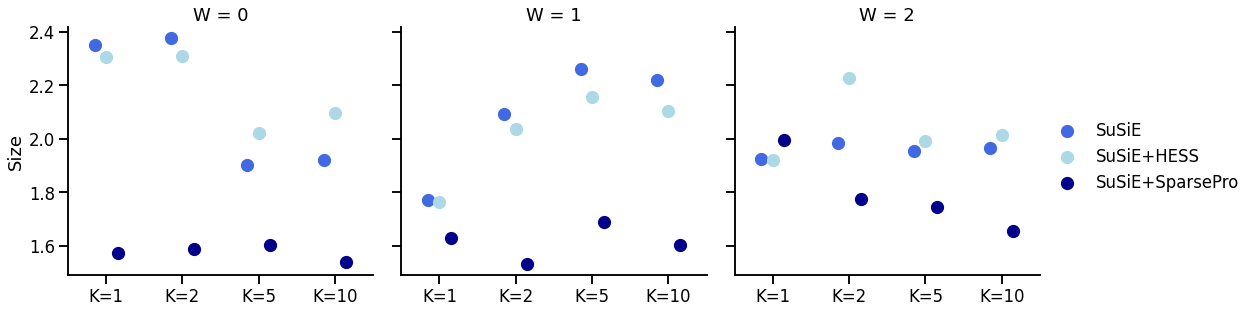

In [28]:
g = sns.catplot(df_cs[df_cs['Method'].isin(['SuSiE', 'SuSiE+HESS', 'SuSiE+SparsePro'])],
                x='K',
                y='Size',
                col='W',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette=color_dict,
                dodge=0.3,
                legend=False)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Size')
g.add_legend(title='')

## Time summary plot

In [38]:
m_dict = {'FINEMAP': 'finemap',
          'SuSiE': 'susie_rss',
          'PAINTOR-': 'PAINTOR_no',
          'PAINTOR+': 'PAINTOR_anno',
          'SparsePro-': 'sparsepro_no',
          'SparsePro+': 'sparsepro_anno_all'}

In [39]:
df_time = pd.read_csv('../doc/loc_time.txt', sep='\t')

In [40]:
df_time_long = pd.melt(df_time, id_vars=['Locus', 'K', 'W'], value_vars=[m for m in m_dict], var_name='Method', value_name='time')

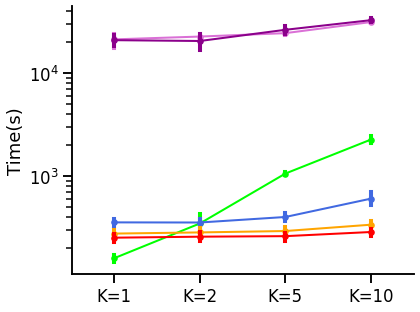

In [41]:
g = sns.catplot(df_time_long, 
            x='K', 
            y='time', 
            hue='Method', 
            kind='point',
            scale = 0.5,
            palette=color_dict,
            legend=False, height=5, aspect=1.3)
g.set_xticks=(range(4))
g.set_xlabel=''
g.set_xticklabels(['K={}'.format(i) for i in [1,2,5,10]])
g.set_axis_labels('','Time(s)')
g.set(yscale='log')

## Annotation summary